In [1]:
# Imports and defaults
from joblib import Parallel, delayed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
from scipy.optimize import linprog
import time

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 1.00
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 8
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

import platform
print("python %s" % platform.python_version())
print("matplotlib %s" % mpl.__version__)

def linestyle2dashes(style):
  if style == "--":
    return (0, (3, 3))
  elif style == ":":
    return (0, (1, 3))
  else:
    return (None, None)

python 3.9.9
matplotlib 3.4.3


In [2]:
# Optimal designs
def a_grad(X, p, gamma=1e-6, return_grad=True):
  n, d = X.shape

  # inverse of the sample covariance matrix
  Xp = X * np.sqrt(p[:, np.newaxis])
  G = Xp.T.dot(Xp) + gamma * np.eye(d)
  invG = np.linalg.inv(G)

  # objective value (trace)
  obj = np.trace(invG)
  if return_grad:
    # gradient of the objective
    V = invG.dot(X.T)
    M = np.einsum("ik,jk->ijk", V, V)
    dp = - np.trace(M)
  else:
    dp = 0

  return obj, dp


def d_grad(X, p, gamma=1e-6, return_grad=True):
  n, d = X.shape

  # inverse of the sample covariance matrix
  Xp = X * np.sqrt(p[:, np.newaxis])
  G = Xp.T.dot(Xp) + gamma * np.eye(d)
  invG = np.linalg.inv(G)

  # objective value (log det)
  _, obj = np.linalg.slogdet(invG)
  if return_grad:
    # gradient of the objective
    V = np.einsum("ki,kj->ijk", X, X)
    M = np.einsum("ilk,lj->ijk", V, invG)
    dp = - np.trace(M)
  else:
    dp = 0

  return obj, dp


def e_grad(X, p, gamma=1e-6):
  n, d = X.shape

  # eigendecomposition of the sample covariance matrix
  Xp = X * np.sqrt(p[:, np.newaxis])
  G = Xp.T.dot(Xp) + gamma * np.eye(d)
  eigvals, eigv = np.linalg.eigh(G)

  v = eigv[:, 0]  # minimum eigenvector
  obj = - eigvals[0]  # objective value (- minimum eigenvalue)
  dp = - np.square(np.dot(X, v))  # gradient of the objective

  return obj, dp


def g_grad(X, p, gamma=1e-6):
  n, d = X.shape

  # inverse of the sample covariance matrix
  Xp = X * np.sqrt(p[:, np.newaxis])
  G = Xp.T.dot(Xp) + gamma * np.eye(d)
  invG = np.linalg.inv(G)

  # objective value
  obj = np.amax((X.dot(invG) * X).sum(axis=-1))

  # gradient of the objective
  xa = X[np.argmax((X.dot(invG) * X).sum(axis=-1)), :]
  dp = - np.square(xa.dot(invG).dot(X.T))

  return obj, dp


def fw_design(X, design="a", pi_0=None, num_iters=100, tol=1e-6, A_ub=None, b_ub=None, printout=True):
  n, d = X.shape

  if pi_0 is None:
    # initial allocation weights are 1 / n and they add up to 1
    pi = np.ones(n) / n
  else:
    pi = np.copy(pi_0)

  if (design == "e") or (design == "g"):
    pi = fw_design(X, "d", pi_0, num_iters, tol, A_ub, b_ub, printout)
    
  # initialize constraints
  if A_ub is None:
    A_ub_fw = np.ones((1, n))
    b_ub_fw = 1
  else:
    A_ub_fw = np.zeros((A_ub.shape[0] + 1, A_ub.shape[1]))
    A_ub_fw[: -1, :] = A_ub
    A_ub_fw[-1, :] = np.ones((1, n))
    b_ub_fw = np.zeros(b_ub.size + 1)
    b_ub_fw[: -1] = b_ub
    b_ub_fw[-1] = 1

  for iter in range(num_iters):
    # compute the gradient
    pi_last = np.copy(pi)
    if design == "a":
      last_obj, grad = a_grad(X, pi_last)
    elif design == "d":
      last_obj, grad = d_grad(X, pi_last)
    elif design == "g":
      last_obj, grad = g_grad(X, pi_last)
    else:
      last_obj, grad = e_grad(X, pi_last)

    if printout:
      print("%.4f" % last_obj, end=" ")

    # find a feasible LP solution in the direction of the gradient
    result = linprog(grad, A_ub_fw, b_ub_fw, bounds=[0, 1], method="revised simplex")
    pi_lp = result.x
    pi_lp = np.maximum(pi_lp, 0)
    pi_lp /= pi_lp.sum()

    # line search in the direction of the gradient
    num_ls_iters = 101
    best_step = 0.0
    best_obj = last_obj
    for ls_iter in range(num_ls_iters):
#       step = np.power(0.667, ls_iter)
      step = ls_iter / (num_ls_iters - 1)
      pi_ = step * pi_lp + (1 - step) * pi_last
      if design == "a":
        obj, _ = a_grad(X, pi_, return_grad=False)
      elif design == "d":
        obj, _ = d_grad(X, pi_, return_grad=False)
      elif design == "g":
        obj, _ = g_grad(X, pi_)
      else:
        obj, _ = e_grad(X, pi_)
      if obj < best_obj:
        best_step = step
        best_obj = obj

    # update solution
    pi = best_step * pi_lp + (1 - best_step) * pi_last

    if last_obj - best_obj < tol:
      break;
    iter += 1
  
  if printout:
    print()

  pi = np.maximum(pi, 0)
  pi /= pi.sum()
  return pi


def fw_safe_design(X, pi_0, alpha, theta_bar, Sigma_bar, num_iters=20):
  n, d = X.shape
  
  pi = fw_design(X, design="g", pi_0=pi_0, printout=False)
  A_ub = np.zeros((num_iters, n))
  b_ub = np.zeros(num_iters)
  
  iter = 1
  while iter < num_iters:
    # find the most violated reward constraint
    c = (alpha * pi_0 - pi).dot(X)
    theta = theta_bar + Sigma_bar.dot(c) / np.sqrt(c.dot(Sigma_bar.dot(c)))
    
    print("%d: %.4f, " % (iter, c.dot(theta)), end="")
    if c.dot(theta) < 1e-6:
      break;
    
    # expand reward constraint set
    A_ub[iter - 1, :] = - X.dot(theta)
    b_ub[iter - 1] = - alpha * pi_0.dot(X).dot(theta)
    pi = fw_design(X, design="g", pi_0=pi_0, A_ub=A_ub[: iter, :], b_ub=b_ub[: iter], printout=False)
    
    iter += 1
  print()

  return pi

21.6286 20.5164 18.8302 17.8415 16.9610 16.5101 16.1262 15.8338 15.6129 15.4008 15.2509 15.1260 15.0024 14.9171 14.8212 14.7514 14.6663 14.6047 14.5553 14.5002 14.4590 14.4250 14.3922 14.3624 14.3308 14.2965 14.2761 14.2554 14.2290 14.1978 14.1780 14.1495 14.1281 14.1092 14.0789 14.0636 14.0513 14.0361 14.0248 14.0127 13.9966 13.9888 13.9770 13.9597 13.9495 13.9321 13.9248 13.9181 13.9013 13.8926 13.8876 13.8770 13.8721 13.8647 13.8594 13.8487 13.8435 13.8381 13.8352 13.8300 13.8255 13.8222 13.8170 13.8134 13.8097 13.8045 13.8017 13.7976 13.7925 13.7905 13.7861 13.7810 13.7791 13.7750 13.7699 13.7676 13.7643 13.7593 13.7565 13.7541 13.7491 13.7459 13.7438 13.7393 13.7358 13.7335 13.7299 13.7260 13.7237 13.7208 13.7166 13.7142 13.7122 13.7076 13.7052 13.7031 13.6990 13.6965 13.6940 13.6907 
Policy             : 0.004 0.004 0.294 0.004 0.004 0.004 0.004 0.335 0.004 0.004 0.004 0.323 0.004 0.004 0.004
Variances          : 3.286 2.956 2.896 2.856 2.853 2.840 2.561 2.539 2.303 2.186 2.162 2

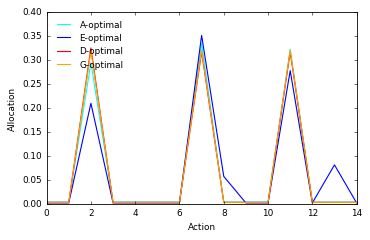

In [3]:
n = 15
d = 3
X = np.random.rand(n, d)
X /= np.sqrt(np.square(X).sum(axis=-1))[:, np.newaxis]
# n = 3
# d = 2
# X = np.asarray([[1.0, 0.0], [1.0, 7.0], [-2.0, 1.0], [10.0, 3.0]])
# X /= np.sqrt(np.square(X).sum(axis=-1))[:, np.newaxis]
designs = [
  ("a", "A-optimal", "cyan"),
  ("e", "E-optimal", "blue"),
  ("d", "D-optimal", "red"),
  ("g", "G-optimal", "orange")]

for design in designs:
  pi = fw_design(X, design=design[0])
  print("Policy             : %s" % " ".join("%.3f" % _ for _ in pi))
  
  Xp = X * np.sqrt(pi[:, np.newaxis])
  invG = np.linalg.inv(Xp.T.dot(Xp))
  vars = np.sort((X.dot(invG) * X).sum(axis=-1))[: : -1]
  print("Variances          : %s" % " ".join("%.3f" % s for s in vars))
  eigvals, eigv = np.linalg.eigh(invG)
  print("Eigenvalues        : %s" % " ".join("%.3f" % s for s in eigvals[: : -1]))
  print("Maximum eigenvector: %s" % " ".join("%.3f" % s for s in eigv[:, -1]))
  print()
  
  plt.plot(pi, design[2], label=design[1])

plt.xlabel("Action")
plt.ylabel("Allocation")
plt.legend(loc="upper left", frameon=False)
plt.show()

In [4]:
X = np.asarray([[1.0, 0.0], [0.0, 1.0]])
X /= np.sqrt(np.square(X).sum(axis=-1))[:, np.newaxis]
n, d = X.shape

sigma = 1.0  # reward noise
pi_0 = np.asarray([0.2, 0.8])
alpha = 0.9
theta_bar = np.asarray([1.0, 2.0])
# theta_bar = np.asarray([2.0, 1.0])
Sigma_bar = np.diag([0.1, 0.1])

# optimal solution
v = np.random.randn(d)
v /= np.sqrt(np.square(v).sum())
theta_star = theta_bar + sqrtm(Sigma_bar).dot(v)
best_arm = np.argmax(X.dot(theta_star))

for method in range(3):
  # compute optimal design
  if method == 0:
    print("*** Optimal design ***")
    pi = fw_design(X, design="d")
  elif method == 1:
    print("*** Naive ***")
    pi = alpha * pi_0 + (1 - alpha) / pi_0.size
  else:
    print("*** SafeOD ***")
    pi = fw_safe_design(X, pi_0, alpha, theta_bar, Sigma_bar)
  print("Policy: %s" % " ".join("%.3f" % _ for _ in pi))
  
  Xp = X * np.sqrt(pi[:, np.newaxis])
  invG = np.linalg.inv(Xp.T.dot(Xp))
  print("Width       : %.3f" % np.sqrt(np.amax((X.dot(invG) * X).sum(axis=-1))))
  
  # evaluate reward loss
  c = (alpha * pi_0 - pi).dot(X)
  map_reward_loss = c.dot(theta_bar)
  max_loss_theta = theta_bar + Sigma_bar.dot(c) / np.sqrt(c.dot(Sigma_bar.dot(c)))
  reward_loss = c.dot(max_loss_theta)
  print("MAP loss    : %.3f" % map_reward_loss)
  print("Maximum loss: %.3f" % reward_loss)
  
  # evaluate off-policy optimization
  gap = np.zeros(1000)
  for i in range(gap.size):
    ndx = np.random.choice(n, size=10 * d, p=pi)
    X_off = X[ndx, :]
    y_off = X_off.dot(theta_star) + sigma * np.random.randn(ndx.size)
    G = X_off.T.dot(X_off) + 1e-3 * np.eye(d)
    theta = np.linalg.solve(G, X_off.T.dot(y_off))    
    arm = np.argmax(X.dot(theta))
    gap[i] = (X[best_arm, :] - X[arm, :]).dot(theta_star)
  
  print("Gap         : %.3f +/- %.3f" % (gap.mean(), gap.std() / np.sqrt(ndx.size)))

*** Optimal design ***
1.3863 
Policy: 0.500 0.500
Width       : 1.414
MAP loss    : 0.120
Maximum loss: 0.243
Gap         : 0.003 +/- 0.013
*** Naive ***
Policy: 0.230 0.770
Width       : 2.085
MAP loss    : -0.150
Maximum loss: -0.128
Gap         : 0.018 +/- 0.033
*** SafeOD ***
1: 0.2443, 2: 0.0019, 3: 0.0000, 
Policy: 0.330 0.670
Width       : 1.741
MAP loss    : -0.050
Maximum loss: 0.000
Gap         : 0.006 +/- 0.020


2 0.95
[1.4184563  2.03101348 1.66406902]
[0.00063102 0.12216272 0.0505966 ]
[ 6.11705843e-01 -2.29599671e-02  9.42806951e-07]
[0.02661398 0.06819355 0.04631381]
[0.00960692 0.01853931 0.01496291]


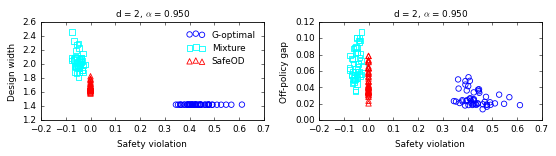

2 0.9
[1.41866189 2.01686864 1.52142607]
[0.00069473 0.12202027 0.02632006]
[ 3.90106173e-01 -4.62381856e-02  8.38831943e-07]
[0.02746489 0.07051717 0.03778583]
[0.01095896 0.02371821 0.01460153]


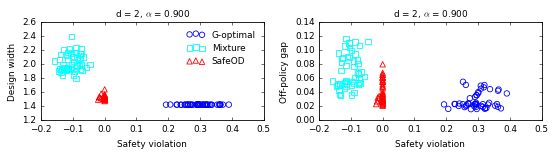

2 0.85
[1.4185371  2.05443665 1.45939531]
[0.00078038 0.10643798 0.01555899]
[ 2.46230167e-01 -7.51450134e-02  4.71665557e-07]
[0.0277159  0.07142904 0.03285137]
[0.01136387 0.02014348 0.01307032]


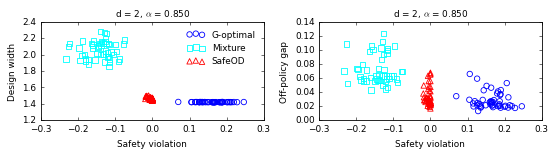

2 0.8
[1.4186472  2.01583845 1.42264725]
[0.00061436 0.10469597 0.00608144]
[ 1.30424165e-01 -9.04333940e-02  3.83632540e-07]
[0.02446235 0.06613448 0.02527399]
[0.00963327 0.02005503 0.0096792 ]


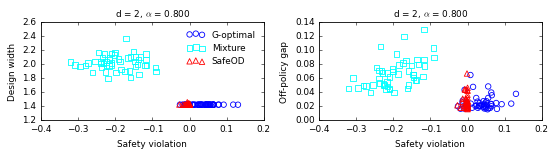

2 0.75
[1.41868459 2.02044793 1.41850542]
[0.00067603 0.1141878  0.00079062]
[ 2.47475872e-03 -1.12977029e-01  2.17951060e-09]
[0.02865292 0.07063117 0.02844835]
[0.01328409 0.02249734 0.01310306]


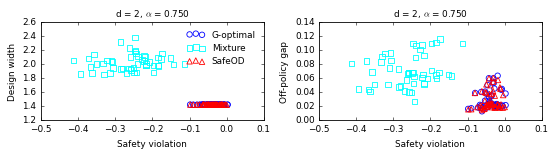

4 0.95
[2.02626148 3.06806429 2.47638227]
[0.00247523 0.22113329 0.09998775]
[ 7.67613088e-01 -5.45368239e-02 -7.92467632e-05]
[0.07442977 0.14688549 0.10769057]
[0.01314385 0.01743761 0.01517582]


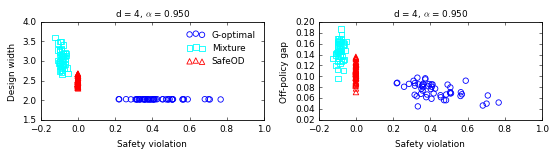

4 0.9
[2.02595367 3.04566278 2.26288252]
[0.00326691 0.1830761  0.06453758]
[ 5.72030104e-01 -1.22641253e-01 -1.19034716e-04]
[0.0760137  0.14873212 0.09304452]
[0.0162421  0.01674004 0.01599814]


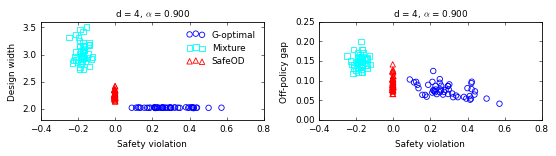

4 0.85
[2.02601857 3.08931126 2.13988075]
[0.00444243 0.20580497 0.07455263]
[ 3.65547245e-01 -1.77201233e-01 -1.28069390e-04]
[0.07761434 0.15128468 0.08169452]
[0.0142798  0.02047707 0.01353055]


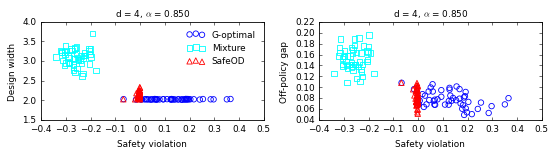

4 0.8
[2.02627884 3.04528569 2.03944564]
[0.00346304 0.172971   0.02832106]
[ 0.17849168 -0.22584167 -0.00379629]
[0.07600142 0.14811456 0.07683161]
[0.01829709 0.01796365 0.0181388 ]


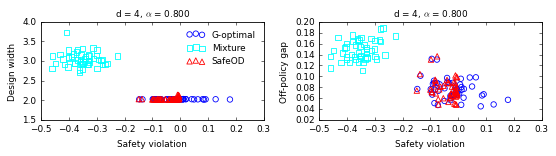

4 0.75
[2.02622595 3.06018999 2.02808338]
[0.00336106 0.19084965 0.00956877]
[ 0.05463127 -0.339462   -0.00923659]
[0.07168728 0.14182974 0.0715486 ]
[0.01549103 0.02530847 0.01491853]


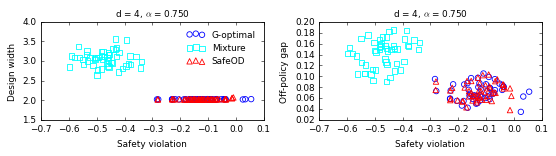

6 0.95
[2.5032457  3.81520917 2.95548771]
[0.00548206 0.29850121 0.12171906]
[ 5.55242284e-01 -8.65592716e-02 -8.53375419e-05]
[0.12030874 0.18895297 0.14525098]
[0.01881738 0.03212219 0.02265565]


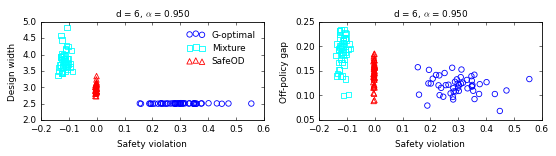

6 0.9
[2.50539262 3.75895919 2.6721924 ]
[0.00516446 0.23111247 0.09022101]
[ 2.62495300e-01 -1.81167723e-01 -7.76529826e-05]
[0.12566902 0.19104528 0.12741889]
[0.02206796 0.02577962 0.02186895]


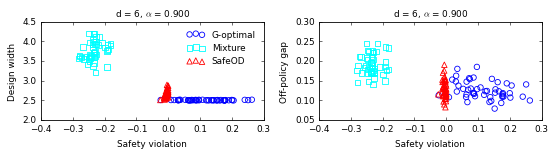

6 0.85
[2.5053244  3.71295688 2.5160419 ]
[0.00596979 0.23464521 0.03922437]
[ 0.15604529 -0.26866751 -0.00052941]
[0.12222499 0.1876714  0.1226752 ]
[0.02214354 0.03084265 0.02224186]


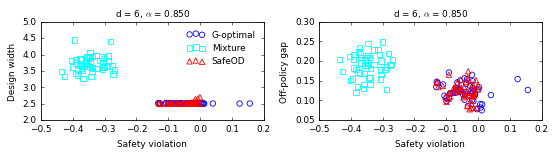

6 0.8
[2.50620901 3.69045897 2.50529407]
[0.00578017 0.23714652 0.00668748]
[-0.03552302 -0.3752058  -0.03245139]
[0.12296095 0.1916312  0.12275544]
[0.02153451 0.03095404 0.02218828]


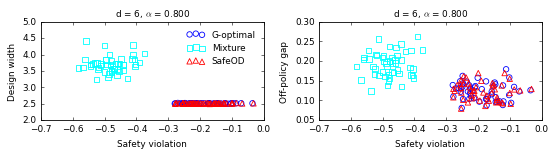

6 0.75
[2.50353493 3.65531267 2.50582812]
[0.00516097 0.21776951 0.00517164]
[-0.17699399 -0.47718891 -0.18857169]
[0.11477517 0.18166874 0.1153614 ]
[0.01698577 0.02275478 0.01730575]


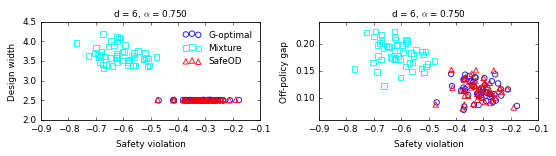

8 0.95
[2.91566519 4.36935799 3.31608842]
[0.00910884 0.24099668 0.10599219]
[ 3.03053956e-01 -1.18618415e-01 -3.85003535e-05]
[0.15674546 0.21851874 0.16816809]
[0.02197492 0.02583508 0.02399414]


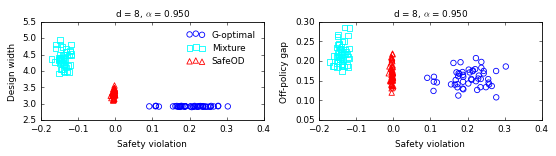

8 0.9
[2.91692818 4.33256287 2.97983179]
[0.00810826 0.2994033  0.07548927]
[ 0.1720579  -0.23763962 -0.00222031]
[0.15812263 0.21971161 0.15809503]
[0.02631715 0.03305363 0.0268903 ]


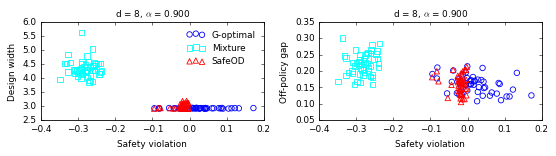

8 0.85
[2.9171171  4.32905738 2.91772117]
[0.00875869 0.29017651 0.00799464]
[-0.02916068 -0.33330897 -0.02831023]
[0.15880069 0.22067284 0.15741787]
[0.02636623 0.03175157 0.02759274]


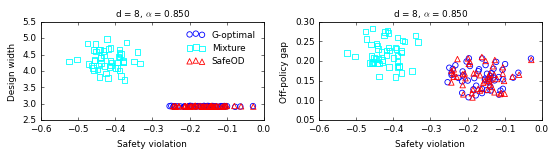

8 0.8
[2.91656736 4.21535102 2.91599951]
[0.0084148  0.29449228 0.00966665]
[-0.20249096 -0.45054941 -0.18588406]
[0.15886644 0.21796925 0.15707792]
[0.02964202 0.03634024 0.02945046]


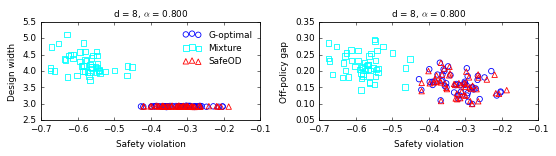

8 0.75
[2.91649019 4.16899183 2.91504495]
[0.00755387 0.25568084 0.00749356]
[-0.33712487 -0.56993623 -0.33812874]
[0.16717661 0.2212475  0.16753276]
[0.02363531 0.02924738 0.0236996 ]


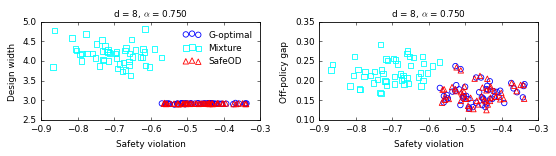

10 0.95
[3.28367359 4.75233777 3.54323465]
[0.00975103 0.25681509 0.14142914]
[ 0.20941332 -0.13044083 -0.0002796 ]
[0.1829734  0.23845775 0.18646519]
[0.03263671 0.03350795 0.03257057]


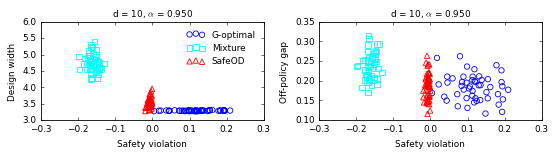

10 0.9
[3.28463876 4.7480792  3.28919055]
[0.00976126 0.27446757 0.01077505]
[ 0.01282082 -0.28540041 -0.00677074]
[0.17629306 0.2293188  0.17625378]
[0.03044427 0.03354296 0.03013907]


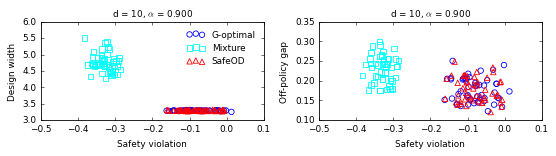

10 0.85
[3.28576877 4.69127455 3.28554118]
[0.01163617 0.28060601 0.01183246]
[-0.16379376 -0.40478587 -0.16409206]
[0.18104516 0.23285957 0.18170775]
[0.02889804 0.03784916 0.02795206]


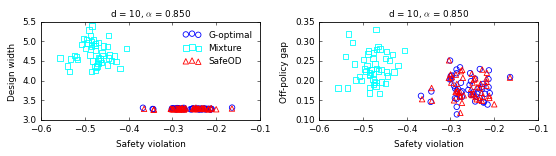

10 0.8
[3.28781046 4.66420375 3.28541496]
[0.00989085 0.23304719 0.01061374]
[-0.29177002 -0.53585874 -0.29441007]
[0.18110154 0.22883246 0.18115671]
[0.02845425 0.03278056 0.02936516]


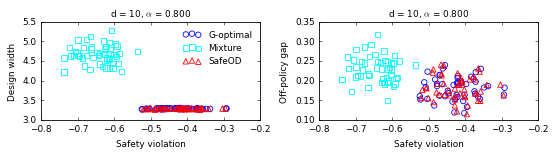

10 0.75
[3.28720461 4.67030792 3.28221472]
[0.01206979 0.28120778 0.00969808]
[-0.46160122 -0.68346227 -0.45962967]
[0.17944111 0.22783504 0.17794353]
[0.0344299  0.0376004  0.03228624]


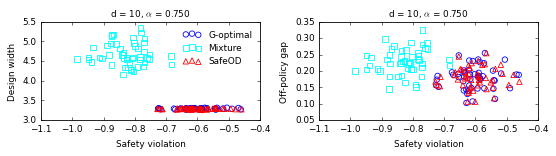

In [5]:
def single_run(run):
  width = np.zeros(3)
  reward_loss = np.zeros(3)
  gap = np.zeros(3)

  X = np.random.rand(n, d)
  X /= np.sqrt(np.square(X).sum(axis=-1))[:, np.newaxis]

  pi_0 = np.random.dirichlet(alpha=np.ones(n))
  theta_bar = np.random.rand(d) + 1
  Sigma_bar = np.square(sigma_bar) * np.eye(d)

  # optimal solution
  v = np.random.randn(d)
  v /= np.sqrt(np.square(v).sum())
  theta_star = theta_bar + sqrtm(Sigma_bar).dot(v)
  best_arm = np.argmax(X.dot(theta_star))

  for method in range(3):
    if method == 0:
#       print("*** Optimal design ***")
      pi = fw_design(X, design="g", printout=False)
    elif method == 1:
#       print("*** Naive ***")
      pi = alpha * pi_0 + (1 - alpha) / pi_0.size
    else:
#       print("*** SafeOD ***")
      pi = fw_safe_design(X, pi_0, alpha, theta_bar, Sigma_bar)

    Xp = X * np.sqrt(pi[:, np.newaxis])
    invG = np.linalg.inv(Xp.T.dot(Xp))
    width[method] = np.sqrt(np.amax((X.dot(invG) * X).sum(axis=-1)))
#     print("Maximum variance: %.3f" % np.amax((X.dot(invG) * X).sum(axis=-1)))

    # evaluate reward loss
    c = (alpha * pi_0 - pi).dot(X)
    map_reward_loss = c.dot(theta_bar)
    max_loss_theta = theta_bar + Sigma_bar.dot(c) / np.sqrt(c.dot(Sigma_bar.dot(c)))
    reward_loss[method] = c.dot(max_loss_theta)
#     print("MAP loss        : %.3f" % map_reward_loss)
#     print("Maximum loss    : %.3f" % reward_loss[run, method])

    # evaluate off-policy optimization
    for i in range(1000):
      ndx = np.random.choice(n, size=10 * d, p=pi)
      X_off = X[ndx, :]
      y_off = X_off.dot(theta_star) + sigma * np.random.randn(ndx.size)
      G = X_off.T.dot(X_off) + 1e-3 * np.eye(d)
      theta = np.linalg.solve(G, X_off.T.dot(y_off))
      arm = np.argmax(X.dot(theta))
      gap[method] += (X[best_arm, :] - X[arm, :]).dot(theta_star)
    gap[method] /= 1000

  return width, reward_loss, gap


n = 100
num_runs = 50
sigma_bar = 1.0

for d in [2, 4, 6, 8, 10]:
  for alpha in [0.95, 0.9, 0.85, 0.8, 0.75]:
    print(d, alpha)
    
    results = Parallel(n_jobs=-1)(delayed(single_run)(run) for run in range(num_runs))
    width = np.vstack(tuple(s[0] for s in results))
    reward_loss = np.vstack(tuple(s[1] for s in results))
    gap = np.vstack(tuple(s[2] for s in results))
    
    print(width[:, :].mean(axis=0))
    print(width[:, :].std(axis=0))
    print(reward_loss[:, :].max(axis=0))
    print(gap[:, :].mean(axis=0))
    print(gap[:, :].std(axis=0))
    
    plt.figure(figsize=(7, 2))
    
    plt.subplot(1, 2, 1)
    plt.scatter(reward_loss[:, 0], width[:, 0],
      s=24, marker="o", edgecolor="blue", facecolor="None",
      label="G-optimal")
    plt.scatter(reward_loss[:, 1], width[:, 1],
      s=24, marker="s", edgecolor="cyan", facecolor="None",
      label="Mixture")
    plt.scatter(reward_loss[:, 2], width[:, 2],
      s=24, marker="^", edgecolor="red", facecolor="None",
      label="SafeOD")
    plt.title(r"d = %d, $\alpha$ = %.3f" % (d, alpha))
    plt.xlabel("Safety violation")
    plt.ylabel("Design width")
    plt.legend(loc="upper right", frameon=False)
    
    plt.subplot(1, 2, 2)
    plt.scatter(reward_loss[:, 0], gap[:, 0],
      s=24, marker="o", edgecolor="blue", facecolor="None")
    plt.scatter(reward_loss[:, 1], gap[:, 1],
      s=24, marker="s", edgecolor="cyan", facecolor="None")
    plt.scatter(reward_loss[:, 2], gap[:, 2],
      s=24, marker="^", edgecolor="red", facecolor="None")
    plt.title(r"d = %d, $\alpha$ = %.3f" % (d, alpha))
    plt.xlabel("Safety violation")
    plt.ylabel("Off-policy gap")
    
    fname = "Results/d=%d_alpha=%.3f" % (d, alpha)
    np.save(fname + "_width.npy", width)
    np.save(fname + "_reward_loss.npy", reward_loss)
    np.save(fname + "_gap.npy", gap)
    
    plt.tight_layout()
    plt.savefig(fname + ".pdf", format="pdf", dpi=1200, bbox_inches=0)
    plt.show()

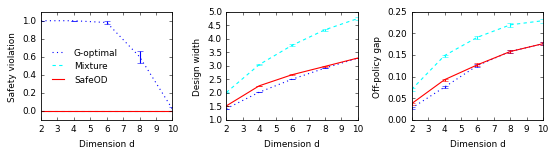

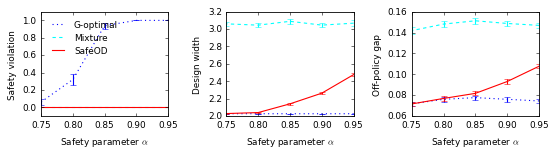

In [6]:
metrics = ["reward_loss", "width", "gap"]
labels = ["Safety violation", "Design width", "Off-policy gap"]
d = np.asarray([2, 4, 6, 8, 10])
alpha = 0.9

plt.figure(figsize=(7, 2))

for i in range(3):
  plt.subplot(1, 3, i + 1)
  
  y = np.zeros((d.size, 3))
  std_y = np.zeros((d.size, 3))
  for j in range(d.size):
    D = np.load("Results/d=%d_alpha=%.3f_%s.npy" % (d[j], alpha, metrics[i]))
    if i == 0:
      D = (D >= 1e-3)
    y[j, :] = D.mean(axis=0)
    std_y[j, :] = D.std(axis=0) / np.sqrt(D.shape[0])
  
  plt.plot(d, y[:, 0], "blue",
    linestyle=linestyle2dashes(":"),
    label="G-optimal" if i == 0 else "")
  plt.errorbar(d, y[:, 0], yerr=std_y[:, 0], ecolor="blue", fmt="none")
  plt.plot(d, y[:, 1], "cyan",
    linestyle=linestyle2dashes("--"),
    label="Mixture" if i == 0 else "")
  plt.errorbar(d, y[:, 1], yerr=std_y[:, 1], ecolor="cyan", fmt="none")
  plt.plot(d, y[:, 2], "red",
    label="SafeOD" if i == 0 else "")
  plt.errorbar(d, y[:, 2], yerr=std_y[:, 2], ecolor="red", fmt="none")
  
  plt.xlabel("Dimension d")
  plt.ylabel(labels[i])
  if i == 0:
    plt.ylim(-0.1, 1.1)
    plt.legend(loc="center left", frameon=False)

plt.tight_layout()
plt.savefig("Results/d.pdf", format="pdf", dpi=1200, bbox_inches=0)
plt.show()

d = 4
alpha = np.asarray([0.95, 0.9, 0.85, 0.8, 0.75])

plt.figure(figsize=(7, 2))

for i in range(3):
  plt.subplot(1, 3, i + 1)
  
  y = np.zeros((alpha.size, 3))
  std_y = np.zeros((alpha.size, 3))
  for j in range(alpha.size):
    D = np.load("Results/d=%d_alpha=%.3f_%s.npy" % (d, alpha[j], metrics[i]))
    if i == 0:
      D = (D >= 1e-3)
    y[j, :] = D.mean(axis=0)
    std_y[j, :] = D.std(axis=0) / np.sqrt(D.shape[0])
  
  plt.plot(alpha, y[:, 0], "blue",
    linestyle=linestyle2dashes(":"),
    label="G-optimal" if i == 0 else "")
  plt.errorbar(alpha, y[:, 0], yerr=std_y[:, 0], ecolor="blue", fmt="none")
  plt.plot(alpha, y[:, 1], "cyan",
    linestyle=linestyle2dashes("--"),
    label="Mixture" if i == 0 else "")
  plt.errorbar(alpha, y[:, 1], yerr=std_y[:, 1], ecolor="cyan", fmt="none")
  plt.plot(alpha, y[:, 2], "red",
    label="SafeOD" if i == 0 else "")
  plt.errorbar(alpha, y[:, 2], yerr=std_y[:, 2], ecolor="red", fmt="none")
  
  plt.xlabel(r"Safety parameter $\alpha$")
  plt.ylabel(labels[i])
  if i == 0:
    plt.ylim(-0.1, 1.1)
    plt.legend(loc="upper left", frameon=False)

plt.tight_layout()
plt.savefig("Results/alpha.pdf", format="pdf", dpi=1200, bbox_inches=0)
plt.show()